# Stock Valuation

This project aims to create a portfolio of stocks to buy. The priority is not to pick winning stocks, but to avoid picking losing stocks. I will aim to do this by assessing the value, growth, income and momentum of the companies in the US and UK stock market, and make a portfolio of these companies. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import requests
from IPython.display import display, clear_output
import time
from datetime import datetime
import logging

## Company Information

This code is a template for use later on when more company information is required to assess the value of a stock.

In [2]:
# Example stock symbol
stock_symbol = 'BRK-A'

# Create a Ticker object
ticker = yf.Ticker(stock_symbol)

# Get stock information
info = ticker.info

# Access specific metrics
pe_ratio = info.get('trailingPE', None)  # P/E ratio
forward_pe = info.get('forwardPE', None)  # Forward P/E ratio
peg_ratio = info.get('pegRatio', None)  # PEG ratio
price_to_book = info.get('priceToBook', None)  # Price/Book ratio
enterprise_to_revenue = info.get('enterpriseToRevenue', None)  # Enterprise Value/Revenue
enterprise_to_ebitda = info.get('enterpriseToEbitda', None)  # Enterprise Value/EBITDA
beta = info.get('beta', None)

# Cash flow data is not directly available through the `info` attribute. 
# You need to use `cashflow` for the cash flow statement:
cash_flow_statement = ticker.cashflow

# Print the metrics
print(f"Stock: {stock_symbol}")
print(f"P/E Ratio: {pe_ratio}")
print(f"Forward P/E Ratio: {forward_pe}")
print(f"PEG Ratio: {peg_ratio}")
print(f"Price to Book Ratio: {price_to_book}")
print(f"Enterprise to Revenue: {enterprise_to_revenue}")
print(f"Enterprise to EBITDA: {enterprise_to_ebitda}")
print(f"Beta: {beta}")
print("\nCash Flow Statement (Annual):")
print(cash_flow_statement)

# Note: The cash flow statement provided here is annual by default. 
# You can get quarterly data by passing `quarterly=True` to `cashflow`.

Stock: BRK-A
P/E Ratio: 9.09918
Forward P/E Ratio: 21.033165
PEG Ratio: -1.54
Price to Book Ratio: 1.5520563
Enterprise to Revenue: 2.32
Enterprise to EBITDA: 6.233
Beta: 0.888

Cash Flow Statement (Annual):
                                                    2023-12-31  \
Free Cash Flow                                   29787000000.0   
Repurchase Of Capital Stock                      -9171000000.0   
Repayment Of Debt                               -11311000000.0   
Issuance Of Debt                                  7817000000.0   
Capital Expenditure                             -19409000000.0   
End Cash Position                                38643000000.0   
Beginning Cash Position                          36399000000.0   
Effect Of Exchange Rate Changes                    116000000.0   
Changes In Cash                                   2128000000.0   
Financing Cash Flow                             -14405000000.0   
Cash Flow From Continuing Financing Activities  -14405000000.0   


In [3]:
logging.basicConfig(level=logging.ERROR)  # Suppress yfinance messages

def calculate_alpha(stock_symbol, benchmark_symbol, risk_free_rate, start_date, end_date):
    try:
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)
        benchmark_data = yf.download(benchmark_symbol, start=start_date, end=end_date, progress=False)

        if stock_data.empty or benchmark_data.empty:
            return np.nan

        stock_returns = stock_data['Adj Close'].pct_change().dropna()
        benchmark_returns = benchmark_data['Adj Close'].pct_change().dropna()

        if stock_returns.std() * np.sqrt(252) > 1:  # Check if annualized volatility is unusually high
            return np.nan  # Consider handling or flagging this differently

        covariance_matrix = np.cov(stock_returns, benchmark_returns)
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        expected_returns = risk_free_rate + beta * (benchmark_returns.mean() * 252 - risk_free_rate)
        actual_returns = (1 + stock_returns.mean())**252 - 1
        alpha = actual_returns - expected_returns

        return round(alpha * 100, 2)
    except Exception:
        return np.nan

# Example usage:
alpha_value = calculate_alpha('BRK-A', '^GSPC', 0.035, '2022-04-19', datetime.now().strftime('%Y-%m-%d'))
print(f"Alpha: {alpha_value if alpha_value is not np.nan else 'N/A'}")

Alpha: 2.66


# Value Analysis

### Information Technology Sector

In [4]:
df = pd.read_csv('us_stock_data.csv')

df.columns

Index(['symbol', 'name', 'exchange', 'assetType', 'ipoDate', 'delistingDate',
       'status', 'sector'],
      dtype='object')

In [5]:
import numpy as np

def fetch_metrics(tickers):
    unique_tickers = list(set(tickers))
    metrics = {
        'symbol': [],
        'Market Cap': [],
        'Trailing P/E': [],
        'P/B Ratio': [],
        'Trailing EPS': [],
        'Forward P/E': [],
        'Forward EPS': [],
        'PEG Ratio': [],
        'Dividend Yield %': [],
        'Beta': [],
        'Alpha %': []
    }
    for ticker in unique_tickers:
        info = yf.Ticker(ticker).info
        metrics['symbol'].append(ticker)
        metrics['Market Cap'].append(float(info.get('marketCap', np.nan)))
        metrics['Trailing P/E'].append(float(info.get('trailingPE', np.nan)))
        metrics['P/B Ratio'].append(float(info.get('priceToBook', np.nan)))
        metrics['Trailing EPS'].append(float(info.get('trailingEps', np.nan)))
        metrics['Forward P/E'].append(float(info.get('forwardPE', np.nan)))
        metrics['Forward EPS'].append(float(info.get('forwardEps', np.nan)))
        metrics['PEG Ratio'].append(float(info.get('peg_ratio', np.nan)))
        metrics['Dividend Yield %'].append(float(info.get('dividendYield', np.nan)) * 100 if info.get('dividendYield') is not None else np.nan)
        metrics['Beta'].append(float(info.get('beta', np.nan)))
        metrics['Alpha %'].append(calculate_alpha(ticker, '^GSPC', 0.035, '2022-04-19', datetime.now().strftime('%Y-%m-%d')))
    return pd.DataFrame(metrics)


def graham_valuation(stock_metrics):
    """Determines if a stock meets Benjamin Graham's criteria for investment."""
    valuation_status = {}
    for index, row in stock_metrics.iterrows():
        meets_criteria = True
        # Check Graham's criteria
        if row['Trailing P/E'] >= 15 or row['Trailing P/E'] * row['P/B Ratio'] >= 22.5:
            meets_criteria = False
        #if row['Current_Ratio'] < 2 or row['Debt_to_Equity'] >= 1:
        #    meets_criteria = False
        # EPS Growth and Dividend Yield can be considered based on availability and specific criteria
        
        valuation_status[row.name] = "Undervalued" if meets_criteria else "Not Undervalued"
    
    return valuation_status

def calculate_benchmarks(df):
    """Calculates benchmarks (median) for a DataFrame of financial metrics."""
    # Select only numeric columns for the median calculation
    numeric_df = df.select_dtypes(include=[np.number])
    return numeric_df.median().to_dict()

def compare_stock_to_benchmarks(stock_metrics, sp500_benchmarks, sector_benchmarks):
    """Compares a single stock's metrics to S&P 500 and sector benchmarks."""
    comparison = {}
    for metric in stock_metrics.index:
        comparison[metric] = {
            'Stock': stock_metrics[metric],
            'S&P 500 Median': sp500_benchmarks.get(metric, np.nan),
            'Sector Median': sector_benchmarks.get(metric, np.nan),
        }
    return comparison

In [6]:
def sector_valuation_status(value, metric, sector_benchmarks):
    """Determines valuation status of a stock based on sector medians for specific metrics."""
    # Define a list of metrics to evaluate
    metrics_to_evaluate = ['Trailing P/E', 'Forward P/E', 'P/B Ratio']
    
    # Check if the metric is one of the specified metrics for comparison
    if metric in sector_benchmarks and metric in metrics_to_evaluate:
        median = sector_benchmarks[metric]
        if value < median * 0.8:
            return 'Undervalued'
        elif value > median * 1.2:
            return 'Overvalued'
        else:
            return 'Fair Value'
    return 'N/A'  # Return 'N/A' for metrics not specified for evaluation

In [7]:
def graham_valuation_status(stock_metrics):
    """Evaluates if a stock meets Benjamin Graham's investment criteria with transition ranges."""
    status = {}

    # Attempt to convert to float, use inf if conversion fails
    try:
        pe_ratio = float(stock_metrics.get('Trailing P/E', float('inf')))
    except ValueError:
        pe_ratio = float('inf')

    try:
        pb_ratio = float(stock_metrics.get('P/B Ratio', float('inf')))
    except ValueError:
        pb_ratio = float('inf')

    # Evaluate P/E Ratio
    if pe_ratio < 15:
        status['Trailing P/E'] = 'Undervalued'
    elif 15 <= pe_ratio <= 20:
        status['Trailing P/E'] = 'Fair Value'
    else:
        status['Trailing P/E'] = 'Overvalued'

    # Evaluate P/B Ratio
    if pb_ratio < 1.5:
        status['P/B Ratio'] = 'Undervalued'
    elif 1.5 <= pb_ratio <= 2:
        status['P/B Ratio'] = 'Fair Value'
    else:
        status['P/B Ratio'] = 'Overvalued'

    # Combined P/E * P/B criterion, introducing a range for transition
    combined_value = pe_ratio * pb_ratio
    if combined_value < 22.5:
        status['Combined P/E x P/B'] = 'Undervalued'
    elif 22.5 <= combined_value <= 27:
        status['Combined P/E x P/B'] = 'Fair Value'
    else:
        status['Combined P/E x P/B'] = 'Overvalued'

    return status

In [8]:
def plot_table_colored(df):
    # Adjust the figure size here (width, height) to make the table bigger
    fig, ax = plt.subplots(figsize=(20, len(df) * 0.5))  # Adding +2 for a bit more space
    ax.axis('tight')
    ax.axis('off')
    
    # Use a larger font size for readability
    plt.rcParams.update({'font.size': 10})
    
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.1 for _ in df.columns])  # Adjust column widths as necessary
    
    # Apply coloring based on valuation status
    for i, col in enumerate(df.columns):
        for j, _ in enumerate(df.index):
            cell_text = table[(j+1, i)].get_text().get_text()
            if "Graham Status" in col:
                # Use one color scheme for Graham-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('green')  # Light blue
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('red')  # Light coral
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('orange')  # Light green
            elif "Sector Status" in col:
                # Use a different color scheme for sector-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#006400')  # Dark green
                    table[(j+1, i)].set_text_props(color='w')
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#8b0000')  # Dark red
                    table[(j+1, i)].set_text_props(color='w')
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('#808080')  # Grey
                    table[(j+1, i)].set_text_props(color='w')
            else:
                # Neutral color for non-valued cells
                table[(j+1, i)].set_facecolor('#f5f5f5')
    
    plt.tight_layout()
    plt.show()

In [9]:
# Extract unique sectors from the 'GICS Sector' column
unique_sectors = df['sector'].unique()

# Convert the array of unique sectors to a list
sector_list = unique_sectors.tolist()

# Print the list of sectors
print(sector_list)

['Healthcare', 'Basic Materials', 'Consumer Defensive', 'Financial Services', 'Industrials', 'Technology', 'Consumer Cyclical', 'Real Estate', 'Energy', 'Communication Services', 'Utilities']


In [10]:
def process_sector(sector_name, df):
    print(f"Processing sector: {sector_name}")
    sector_companies = df[df['sector'] == sector_name]['symbol'].tolist()
    sector_data = fetch_metrics(sector_companies)
    sector_benchmarks = calculate_benchmarks(sector_data)
    
    results = []
    for _, metrics in sector_data.iterrows():
        graham_status = graham_valuation_status(metrics)
        
        # Applying sector valuation status only to specific metrics
        sector_status = {metric: sector_valuation_status(metrics[metric], metric, sector_benchmarks) 
                         for metric in ['Trailing P/E', 'Forward P/E', 'P/B Ratio'] if metric in metrics}
        
        row = {
            'Ticker': metrics['symbol'],  # Assuming 'symbol' is part of the metrics DataFrame
            **metrics,
            **{f'{metric} Graham Status': status for metric, status in graham_status.items()},
            **{f'{metric} Sector Status': status for metric, status in sector_status.items()}
        }
        results.append(row)

    df_results = pd.DataFrame(results)

    return df_results, len(sector_companies) 

In [11]:
def main_process(df):
    unique_sectors = df['sector'].unique()
    total_sectors = len(unique_sectors)
    processed_count = 0
    start_time = time.time()
    
    sector_results_dict = {}

    for sector in unique_sectors:
        df_sector_results, num_stocks = process_sector(sector, df)
        sector_results_dict[sector] = df_sector_results
        
        processed_count += 1
        stocks_remaining = sum(df[df['sector'] == s]['symbol'].count() for s in unique_sectors[processed_count:])  # Calculate remaining stocks

        # Dynamic update of the progress
        clear_output(wait=True)
        display(f"Processed {processed_count}/{total_sectors} sectors. ({processed_count/total_sectors * 100:.2f}%) - "
                f"Total stocks processed in current sector: {num_stocks}")

    print("All sectors processed successfully.")
    return sector_results_dict

# Example usage assuming 'df' is your DataFrame loaded with stock data including sectors
sector_results = main_process(df)

'Processed 11/11 sectors. (100.00%) - Total stocks processed in current sector: 100'

All sectors processed successfully.


In [12]:
# Initialize the dictionary to store undervalued stocks by sector
undervalued_stocks_by_sector = {}

# Initialize an empty DataFrame to store results from all sectors
all_sectors_df = pd.DataFrame()

for sector in unique_sectors:
    # Access the pre-processed DataFrame for each sector from sector_results_dict
    df_sector_results = sector_results.get(sector, pd.DataFrame())

    if not df_sector_results.empty:
        # Extract tickers of undervalued stocks based on the "Combined P/E x P/B Graham Status"
        undervalued_stocks = df_sector_results[df_sector_results['Combined P/E x P/B Graham Status'] == 'Undervalued'].copy()
        
        # Add sector information to each row safely using .loc
        undervalued_stocks.loc[:, 'sector'] = sector
        
        # Append the undervalued stocks of the current sector to the all_sectors_df DataFrame
        all_sectors_df = pd.concat([all_sectors_df, undervalued_stocks], ignore_index=True)
    
        # Calculate and print the number of undervalued stocks per sector
        undervalued_stocks_by_sector[sector] = undervalued_stocks['Ticker'].tolist()
        print(f'Sector: {sector} - Undervalued stocks: {len(undervalued_stocks_by_sector[sector])} ({100*len(undervalued_stocks_by_sector[sector])/len(df_sector_results):.1f}%)')

# Save the consolidated DataFrame to CSV
all_sectors_df.to_csv('undervalued_stocks_by_sector.csv', index=False)

Sector: Healthcare - Undervalued stocks: 33 (2.8%)
Sector: Basic Materials - Undervalued stocks: 42 (19.4%)
Sector: Consumer Defensive - Undervalued stocks: 45 (19.1%)
Sector: Financial Services - Undervalued stocks: 455 (47.2%)
Sector: Industrials - Undervalued stocks: 88 (14.1%)
Sector: Technology - Undervalued stocks: 55 (7.3%)
Sector: Consumer Cyclical - Undervalued stocks: 104 (18.6%)
Sector: Real Estate - Undervalued stocks: 49 (19.8%)
Sector: Energy - Undervalued stocks: 101 (46.3%)
Sector: Communication Services - Undervalued stocks: 42 (17.1%)
Sector: Utilities - Undervalued stocks: 25 (25.0%)


In [13]:
#all_sectors_df[all_sectors_df['sector'] == 'Technology'].sort_values(by='P/B Ratio', ascending=True)

filtered_df = all_sectors_df[(all_sectors_df['Forward P/E'] >= 0) & (all_sectors_df['Alpha %'] > 1.5) & (all_sectors_df['sector'] == 'Financial Services')]
sorted_filtered_df = filtered_df.sort_values(by='Forward P/E', ascending=True)
sorted_filtered_df

Ticker symbol    Market Cap  Trailing P/E  P/B Ratio  Trailing EPS  \
476   FINV   FINV  1.324963e+09      4.113044   0.092403         1.150   
384    MFG    MFG  4.878375e+10     11.636363   0.000987         0.330   
134    JXN    JXN  4.933652e+09      5.984201   0.525573        10.760   
162   QFIN   QFIN  2.909599e+09      5.300000   0.129919         3.400   
542   MFIN   MFIN  1.850508e+08      3.324895   0.515876         2.370   
..     ...    ...           ...           ...        ...           ...   
333    IBN    IBN  8.929871e+10     17.908451   0.073096         1.420   
135    RKT    RKT  2.291357e+10      6.398446   2.505977         1.802   
559  BRK-A  BRK-A  8.647959e+11      9.099180   1.552056     66395.430   
167      L      L  1.639780e+10     11.739268   1.044635         6.290   
231    WTM    WTM  4.469681e+09      8.771751   1.036433       198.600   

     Forward P/E  Forward EPS  PEG Ratio  Dividend Yield %   Beta  Alpha %  \
476     3.153333         1.50        NaN              5.01  0.434    16.75   
384     3.282051         1.17        NaN              3.34  0.488    23.06   
134     3.619449        17.79        NaN              4.35  1.579    24.11   
162     3.640404         4.95        NaN              5.99  0.617    26.01   
542     3.959799         1.99        NaN              5.06  2.077     3.17   
..           ...          ...        ...               ...    ...      ...   
333    17.783218         1.43        NaN              0.76  0.814     9.42   
135    20.228070         0.57        NaN               NaN  2.386    18.93   
559    21.033165     28723.40        NaN               NaN  0.888     2.66   
167    25.462067         2.90        NaN              0.34  0.822     1.89   
231    29.034498        60.00        NaN              0.06  0.418    26.89   

    Trailing P/E Graham Status P/B Ratio Graham Status  \
476                Undervalued             Undervalued   
384                Undervalued             Undervalued   
134                Undervalued             Undervalued   
162                Undervalued             Undervalued   
542                Undervalued             Undervalued   
..                         ...                     ...   
333                 Fair Value             Undervalued   
135                Undervalued              Overvalued   
559                Undervalued              Fair Value   
167                Undervalued             Undervalued   
231                Undervalued             Undervalued   

    Combined P/E x P/B Graham Status Trailing P/E Sector Status  \
476                      Undervalued                Undervalued   
384                      Undervalued                 Fair Value   
134                      Undervalued                Undervalued   
162                      Undervalued                Undervalued   
542                      Undervalued                Undervalued   
..                               ...                        ...   
333                      Undervalued                 Overvalued   
135                      Undervalued                Undervalued   
559                      Undervalued                Undervalued   
167                      Undervalued                 Fair Value   
231                      Undervalued                Undervalued   

    Forward P/E Sector Status P/B Ratio Sector Status              sector  
476               Undervalued             Undervalued  Financial Services  
384               Undervalued             Undervalued  Financial Services  
134               Undervalued             Undervalued  Financial Services  
162               Undervalued             Undervalued  Financial Services  
542               Undervalued             Undervalued  Financial Services  
..                        ...                     ...                 ...  
333                Overvalued             Undervalued  Financial Services  
135                Overvalued              Overvalued  Financial Ser

In [14]:
def plot_valuation_table(df):
    print(f"Valuation Table")
    columns_to_display = ['symbol'] + [col for col in df.columns if 'Status' in col]
    plot_table_colored(df[columns_to_display])

def plot_sector_valuation_table(df, sector_name):
    print(f"Valuation Table for {sector_name} Sector")
    # Filter the DataFrame for the given sector
    sector_df = df[df['sector'] == sector_name]
    
    # Select columns that include 'Status' in their names plus the 'symbol' column
    columns_to_display = ['symbol'] + [col for col in sector_df.columns if 'Status' in col]
    
    # Plot the table with the filtered DataFrame
    plot_table_colored(sector_df[columns_to_display])

In [15]:
plot_valuation_table(all_sectors_df)

Valuation Table


In [16]:
def plot_pe_ratios(df, sector_name):
    plt.figure(figsize=(14, 7))
    plt.title(f'P/E Ratios for {sector_name} Sector')
    plt.xlabel('Company Ticker')
    plt.ylabel('Trailing P/E Ratio')

    # Determine colors based on valuation status
    colors = df['Combined P/E x P/B Graham Status'].map({
        'Undervalued': 'green',
        'Fair Value': 'orange',
        'Overvalued': 'red',
        'N/A': 'gray'
    })

    # Plot each company's P/E ratio
    plt.scatter(df['Ticker'], df['Trailing P/E'], color=colors, alpha=0.7, s=100)

    # Optional: Add sector median P/E ratio line
    sector_median_pe = df['Trailing P/E'].median()
    plt.axhline(y=sector_median_pe, color='blue', linestyle='--', label=f'Sector Median P/E: {sector_median_pe:.2f}')

    plt.xticks(rotation=90)  # Rotate company tickers for better readability
    plt.legend()
    plt.tight_layout()
    plt.show()

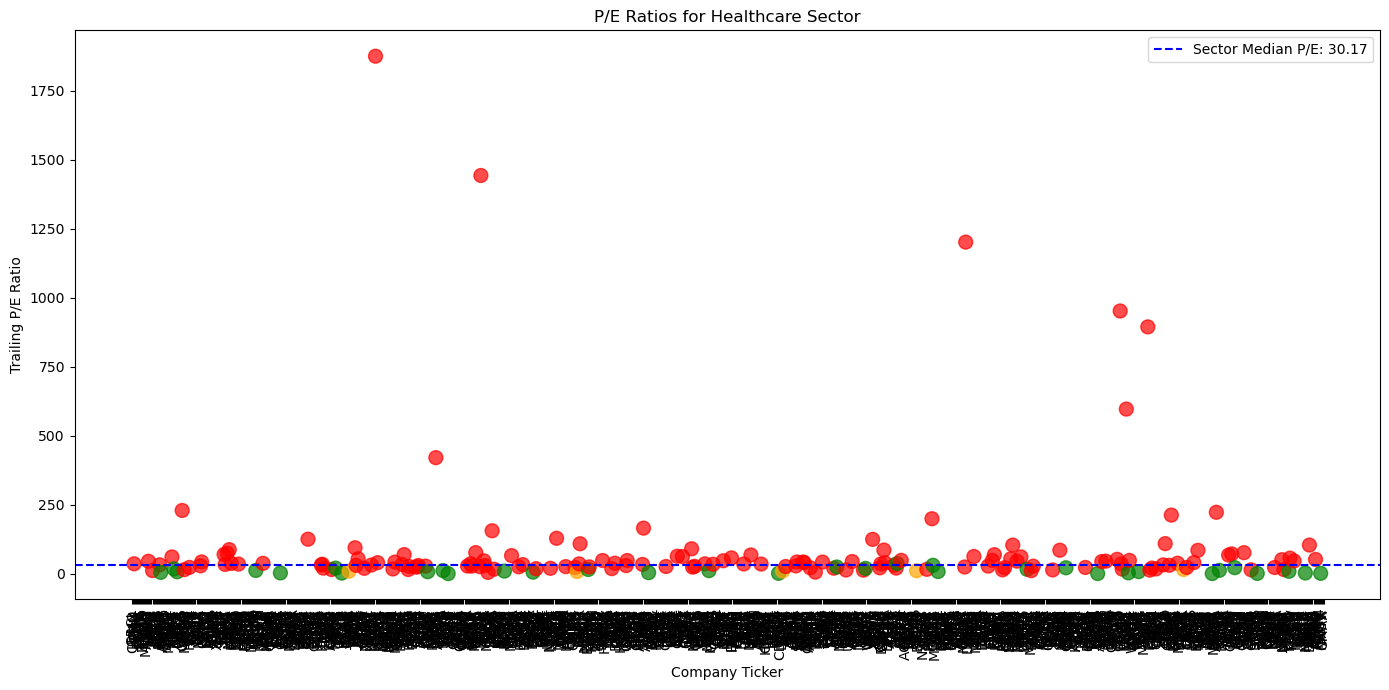

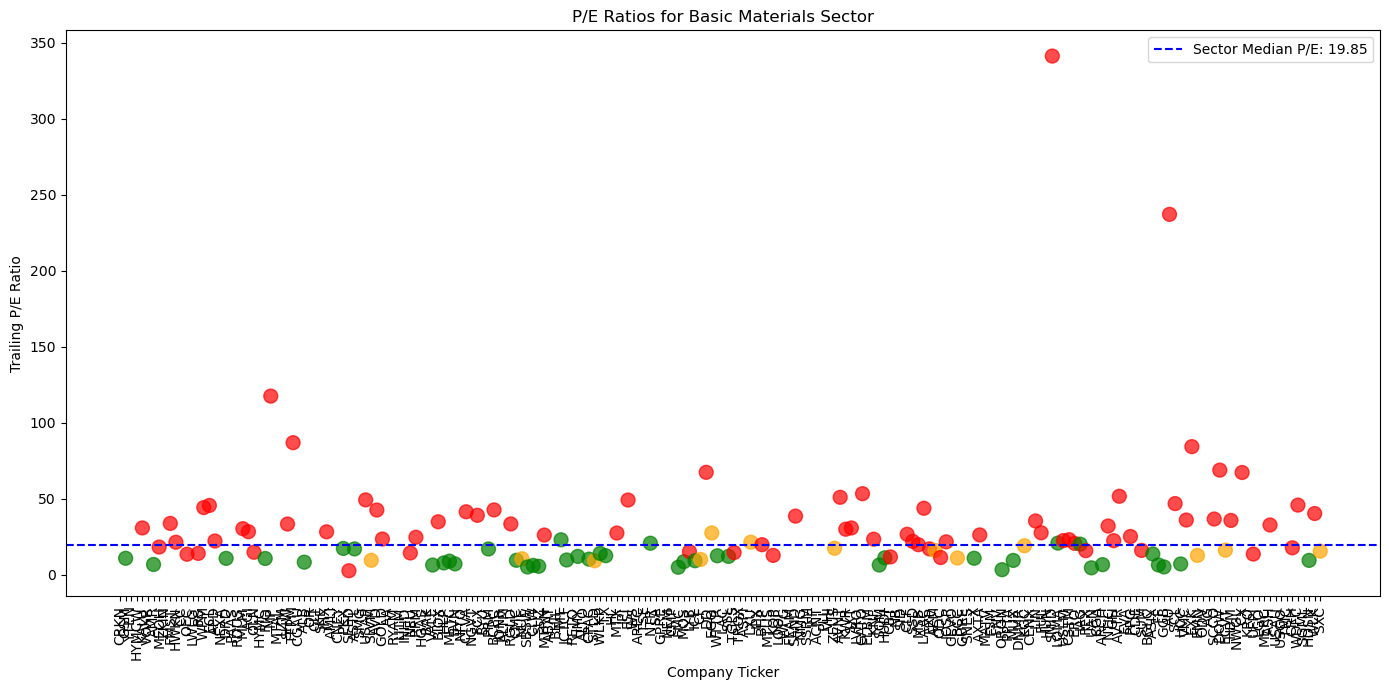

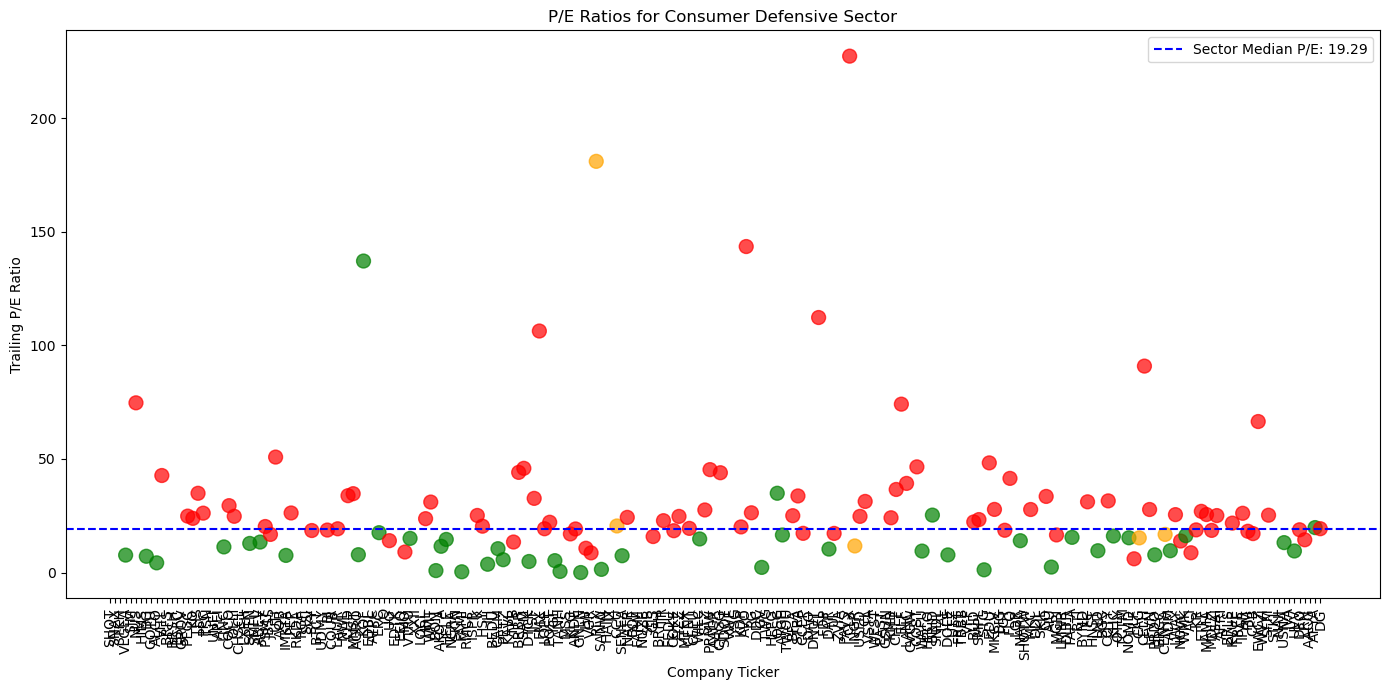

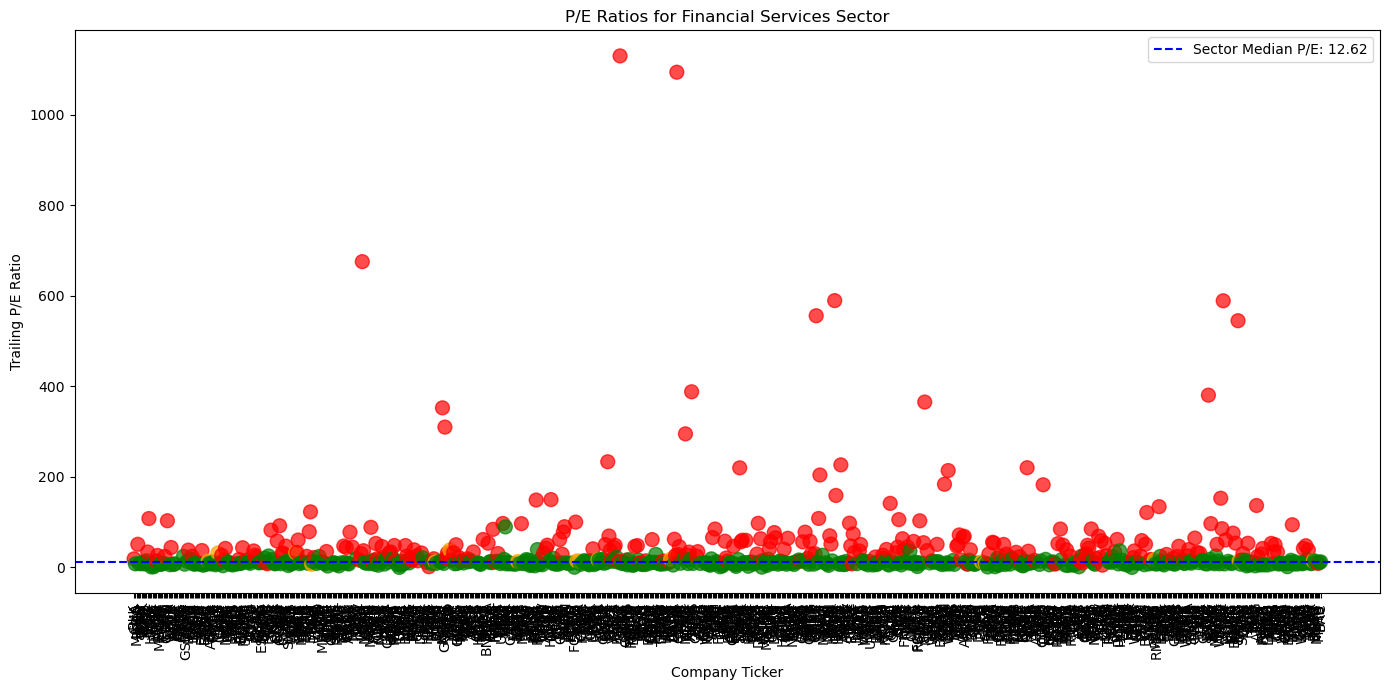

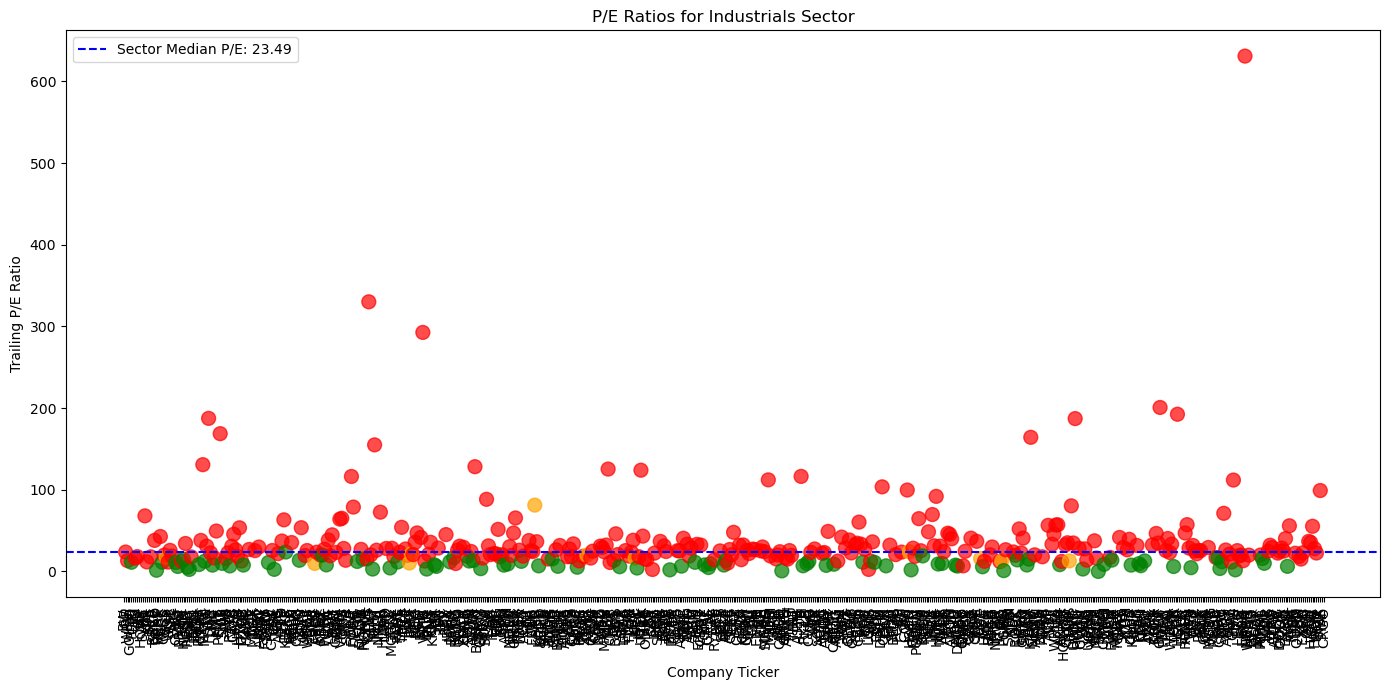

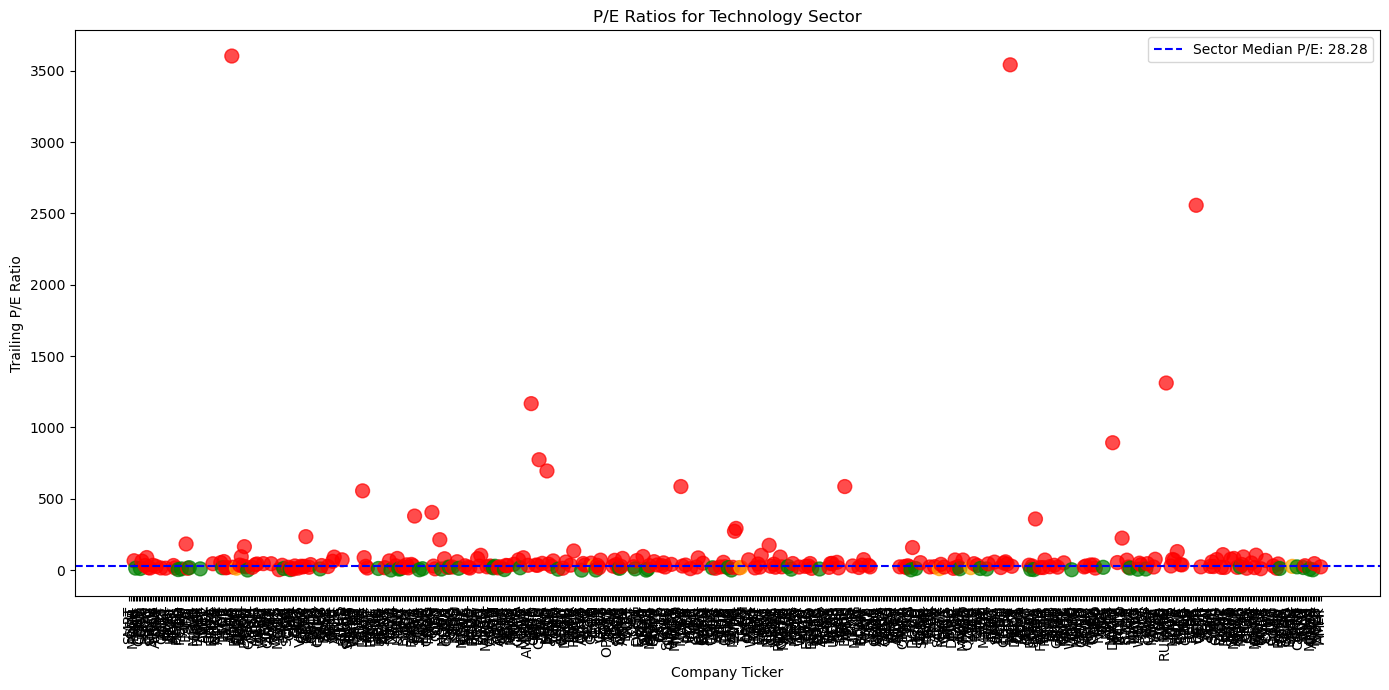

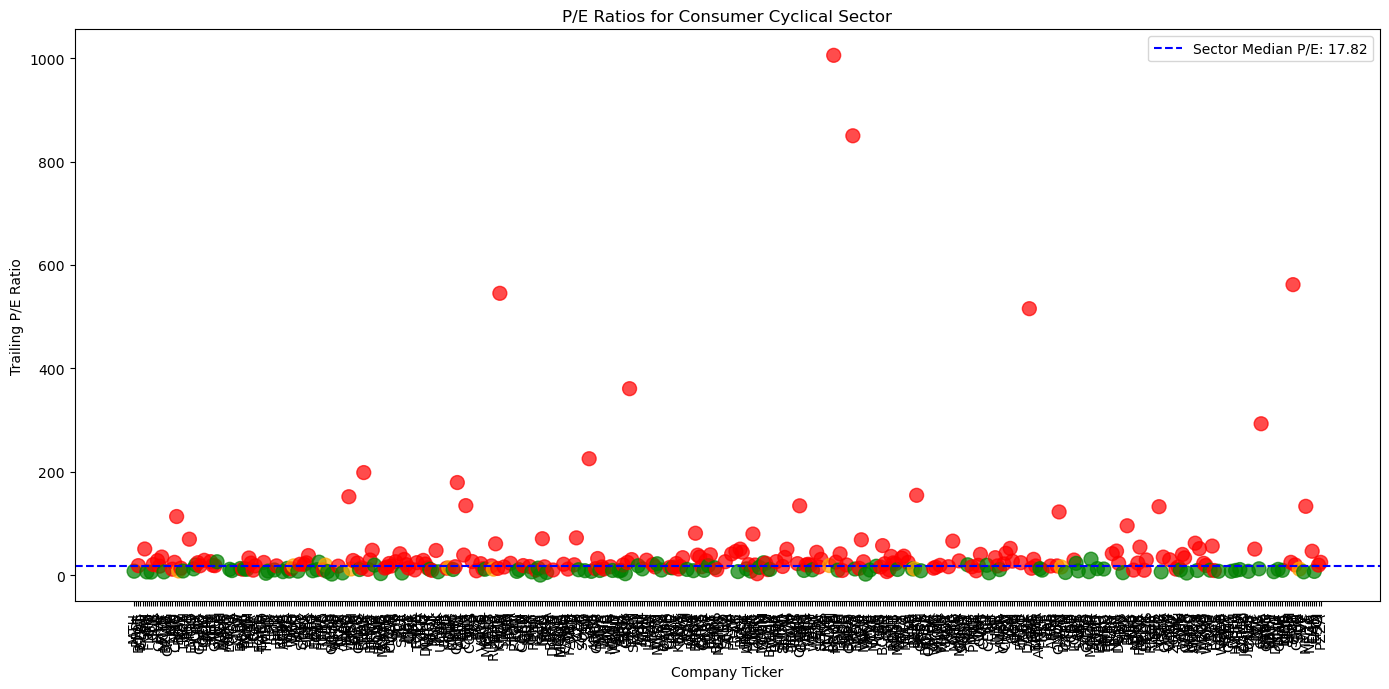

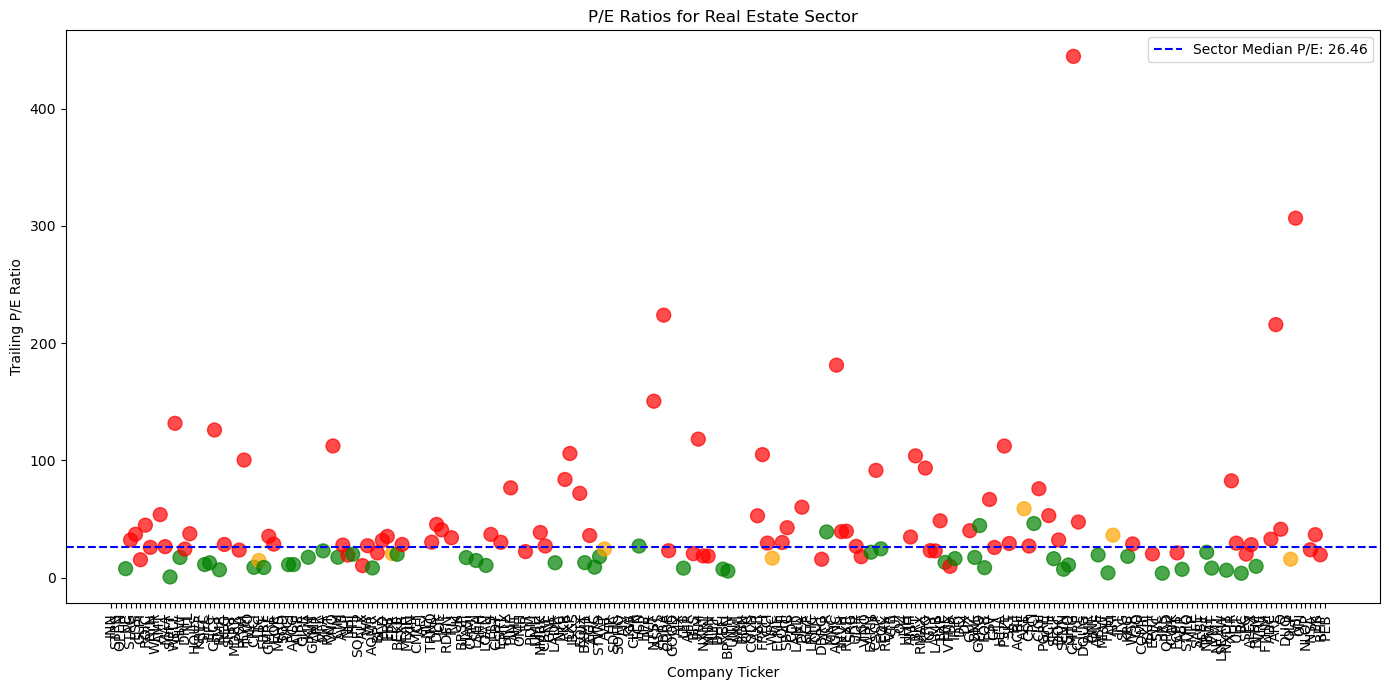

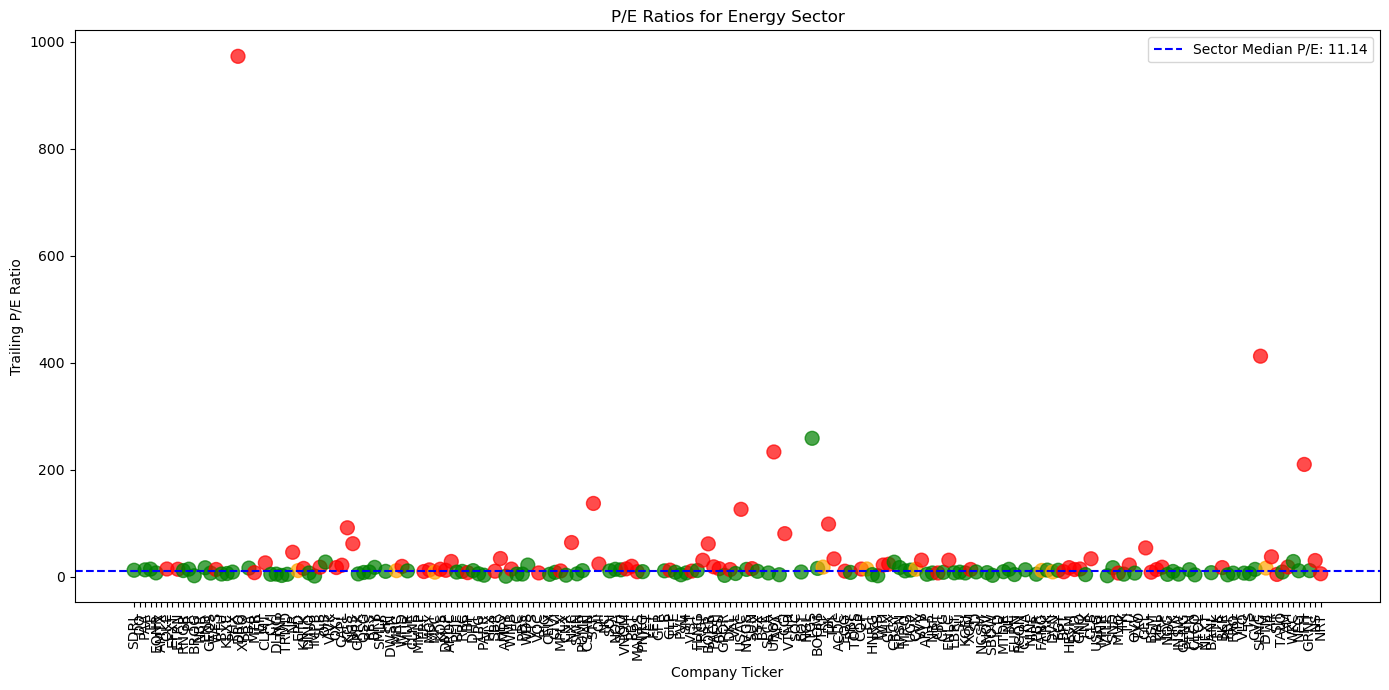

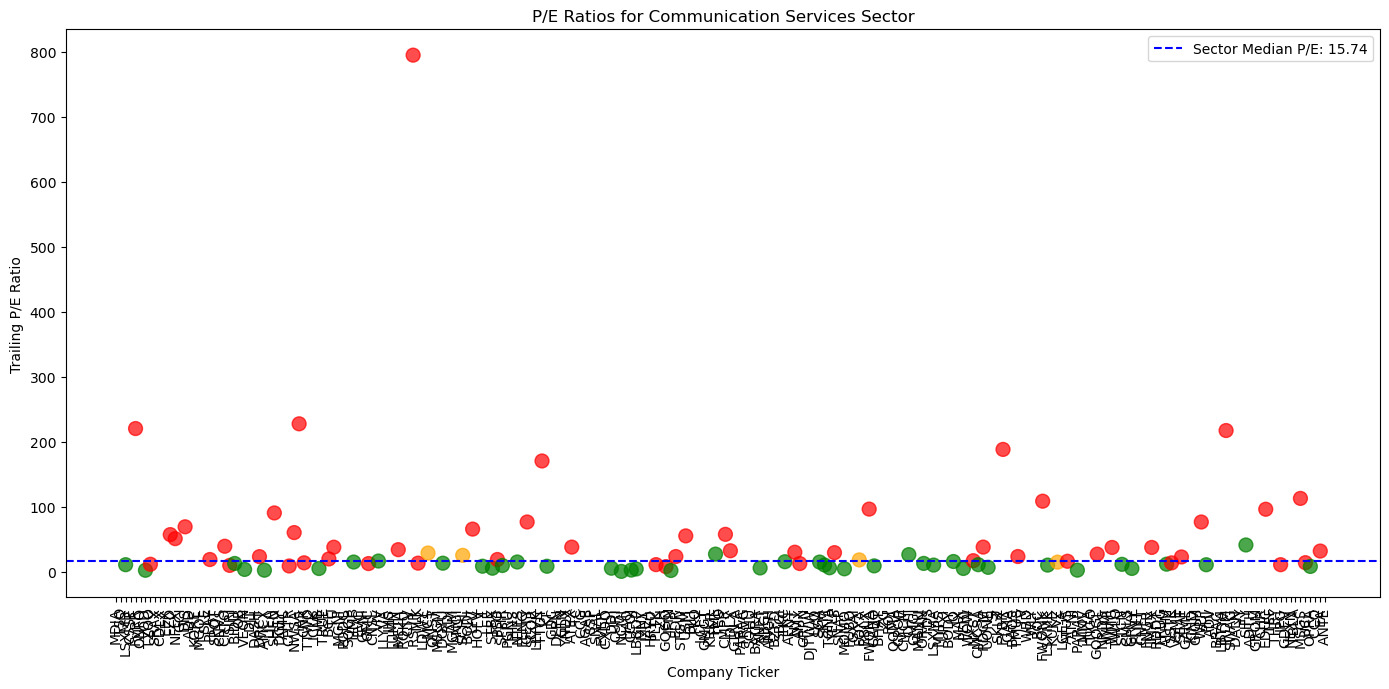

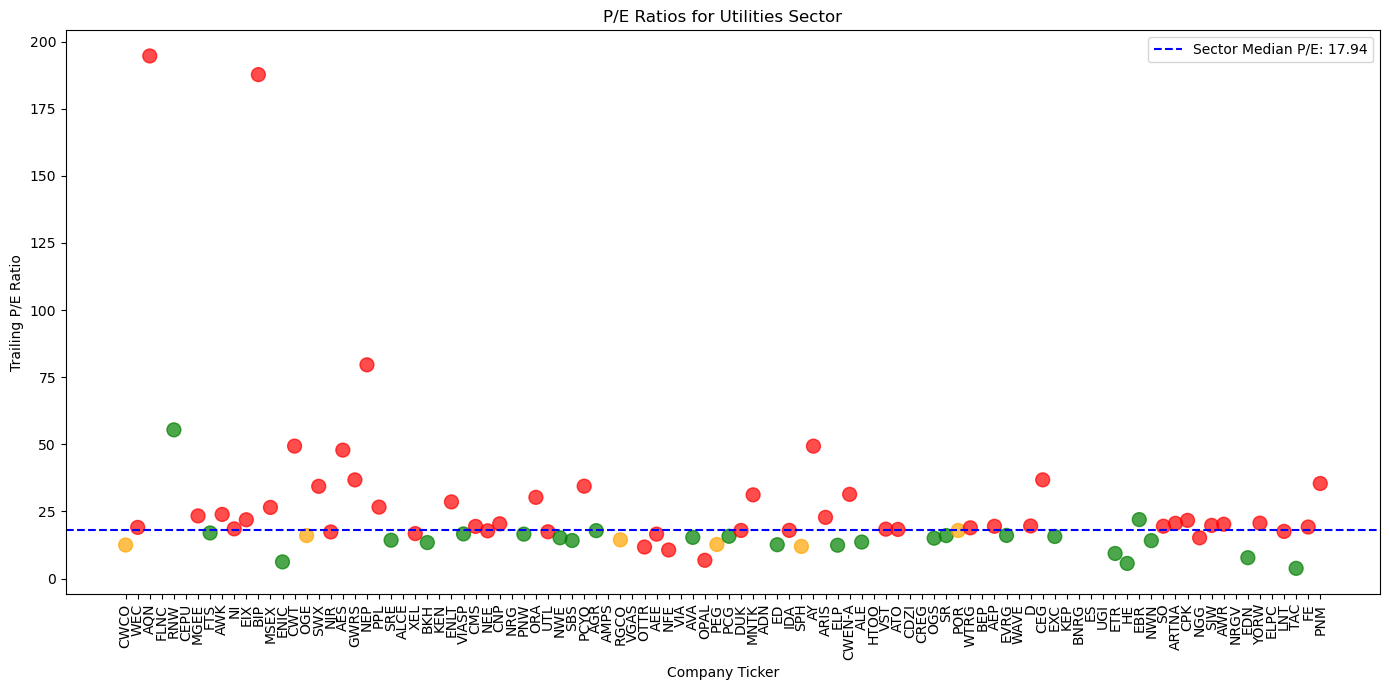

In [17]:
for sector in unique_sectors:
    df_sector_results = sector_results.get(sector, pd.DataFrame())
    plot_pe_ratios(df_sector_results, sector)

In [18]:
import numpy as np

def plot_pe_pb_with_marketcap(df):
    # Ensure Market Cap is in a suitable scale (e.g., billions) and convert to a size for the plot
    df['MarketCap_Billions'] = df['Market Cap'] / 1e9
    sizes = df['MarketCap_Billions'] * 10  # Scale market cap sizes for visibility

    # Create the scatter plot
    plt.figure(figsize=(14, 8))
    plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')
    
    # Loop through the DataFrame and add ticker symbols as text labels for each bubble
    for i, row in df.iterrows():
        # Check if both PB_Ratio and Trailing P/E are finite numbers
        if np.isfinite(row['P/B Ratio']) and np.isfinite(row['Trailing P/E']):
            plt.text(row['P/B Ratio'], row['Trailing P/E'], row['Ticker'], 
                     ha='center', va='center', fontsize=8, color='black', alpha=0.7)
    
    plt.title('P/B Ratio vs. Trailing P/E with Market Cap Size Indicator')
    plt.xlabel('P/B Ratio')
    plt.ylabel('Trailing P/E Ratio')
    plt.xscale('log')  # Using log scale for P/B Ratio if wide range values are expected
    plt.yscale('log')  # Using log scale for P/E Ratio to handle wide range of values and outliers

    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [19]:
'''
******
Use this if you want to plot all the data in one figure, but it gets quite messy
******

# Initialize an empty DataFrame
all_sectors_df = pd.DataFrame()

for sector, df in sector_results_dict.items():
    # Optionally, add a sector column to each sector's DataFrame before concatenation
    df['Sector'] = sector
    # Concatenate the current sector's DataFrame to the comprehensive DataFrame
    all_sectors_df = pd.concat([all_sectors_df, df], ignore_index=True)
'''

"\n******\nUse this if you want to plot all the data in one figure, but it gets quite messy\n******\n\n# Initialize an empty DataFrame\nall_sectors_df = pd.DataFrame()\n\nfor sector, df in sector_results_dict.items():\n    # Optionally, add a sector column to each sector's DataFrame before concatenation\n    df['Sector'] = sector\n    # Concatenate the current sector's DataFrame to the comprehensive DataFrame\n    all_sectors_df = pd.concat([all_sectors_df, df], ignore_index=True)\n"

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


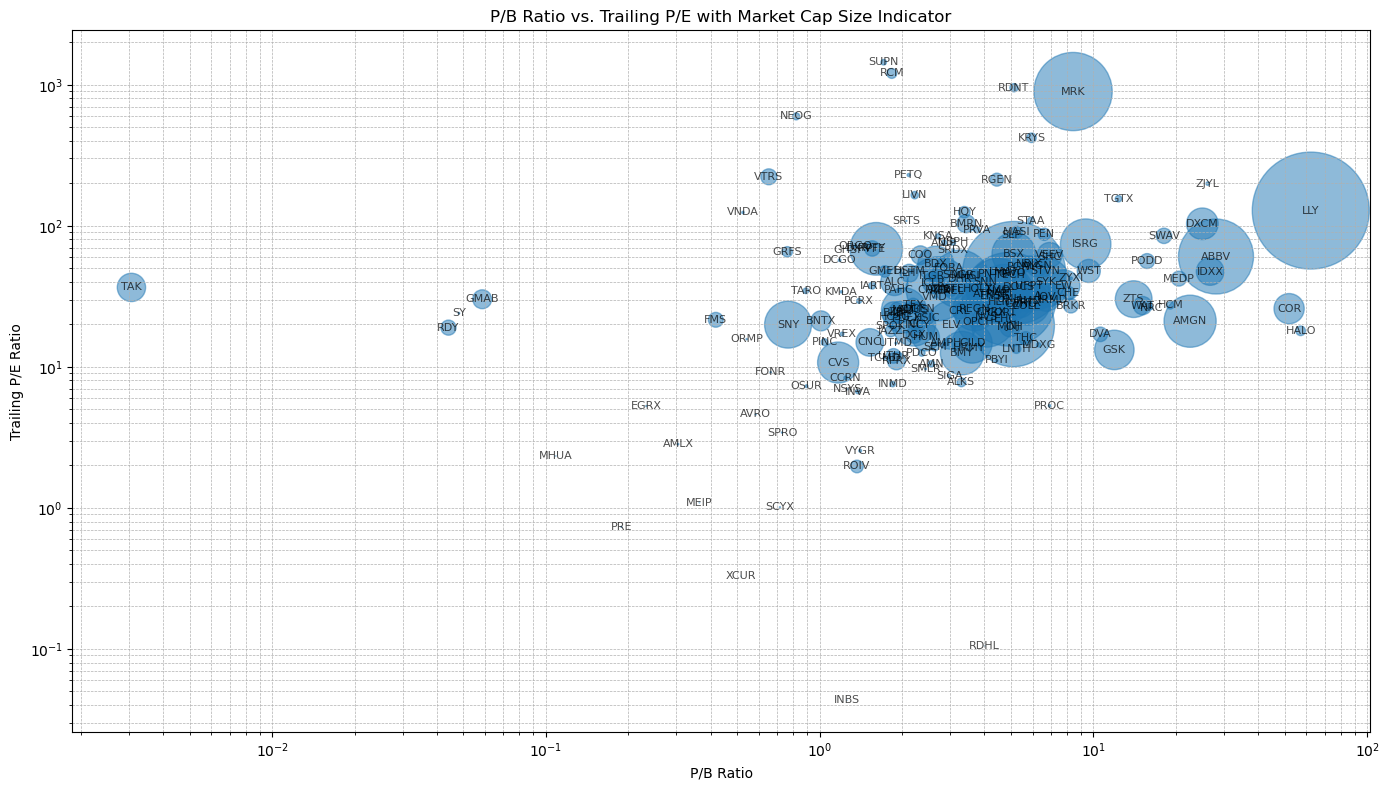

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


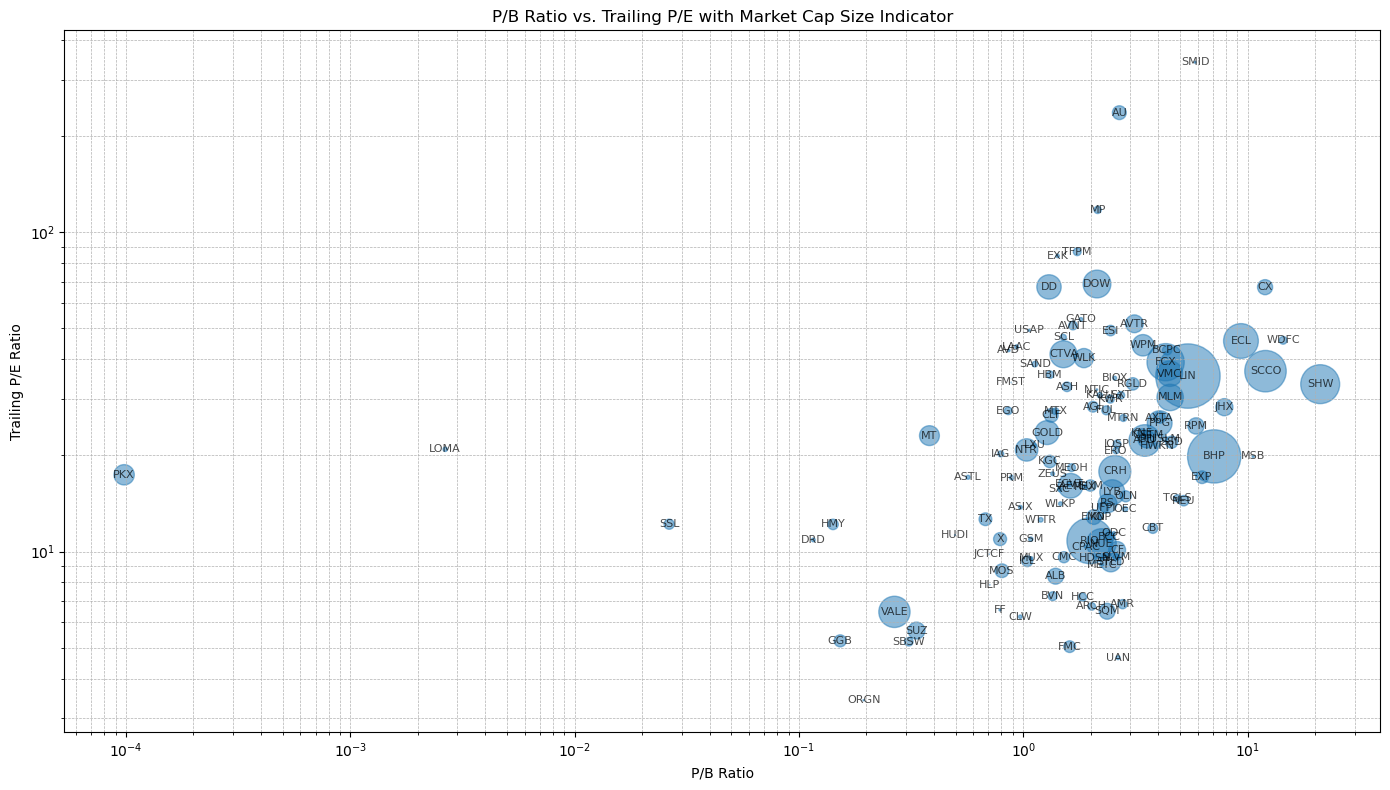

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


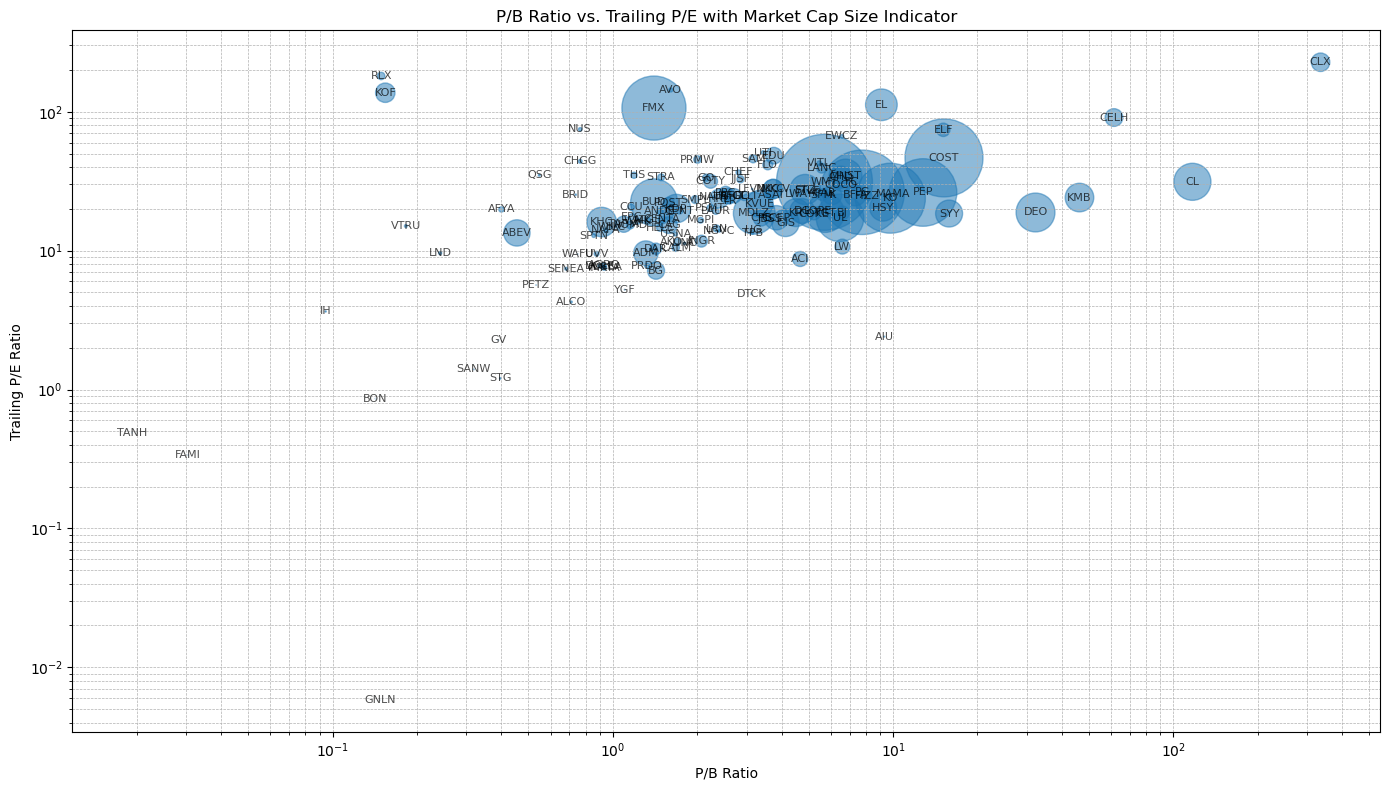

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


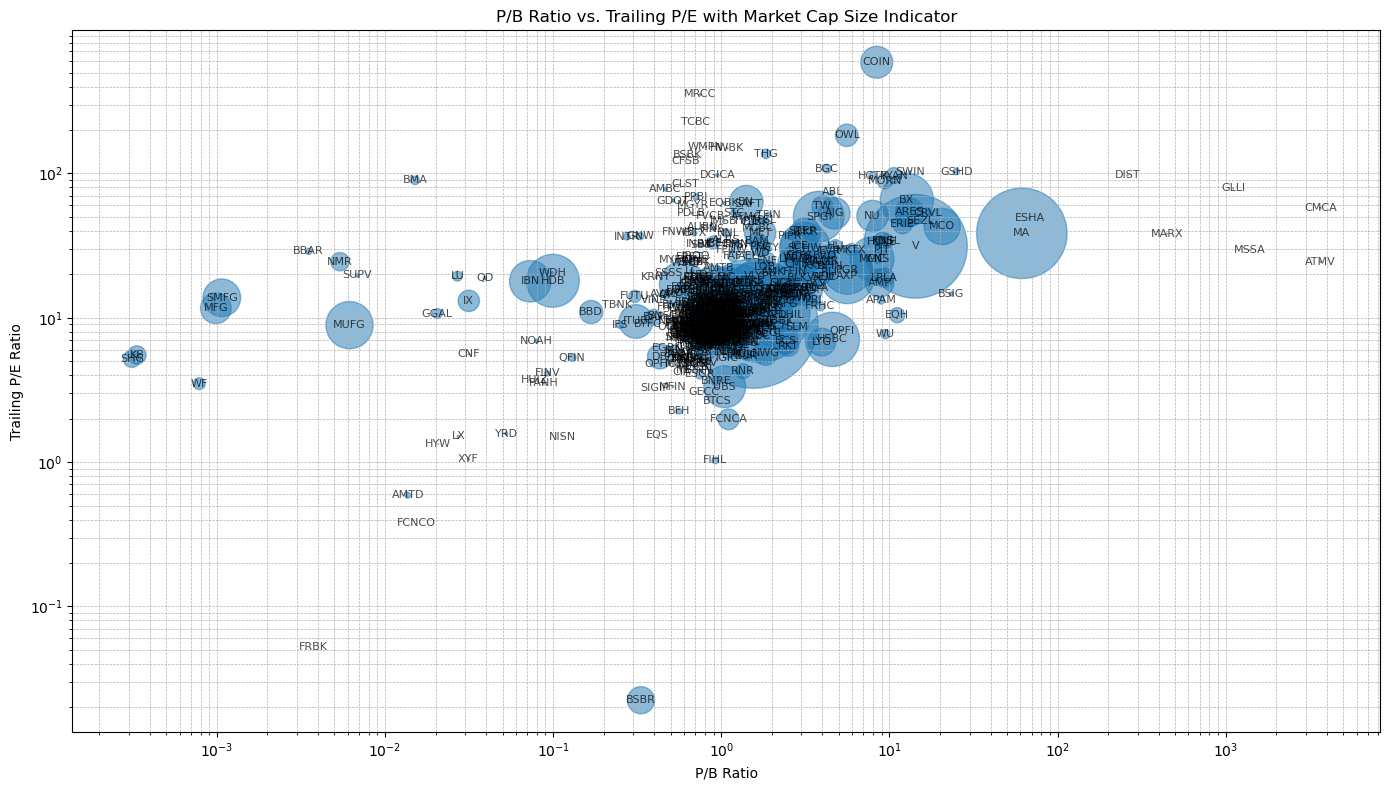

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


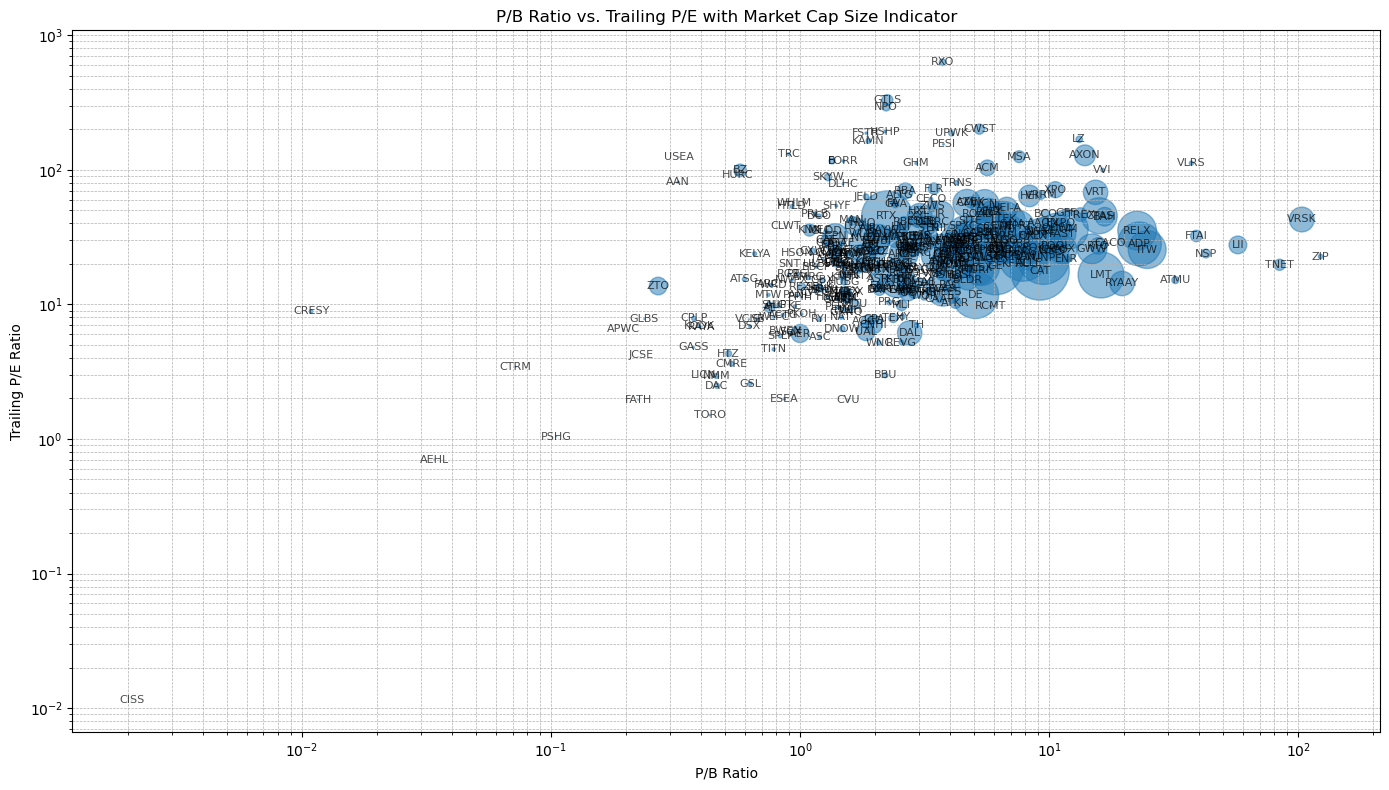

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


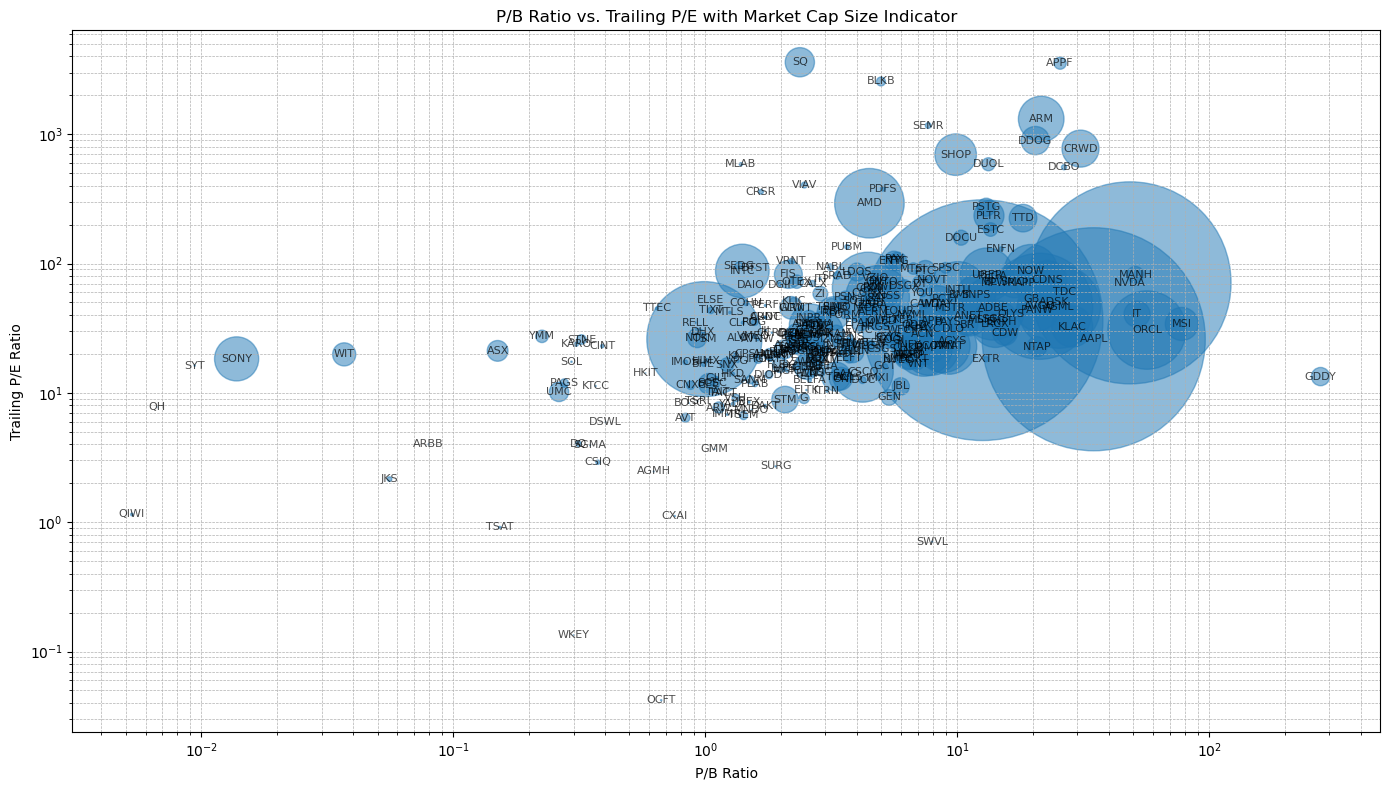

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


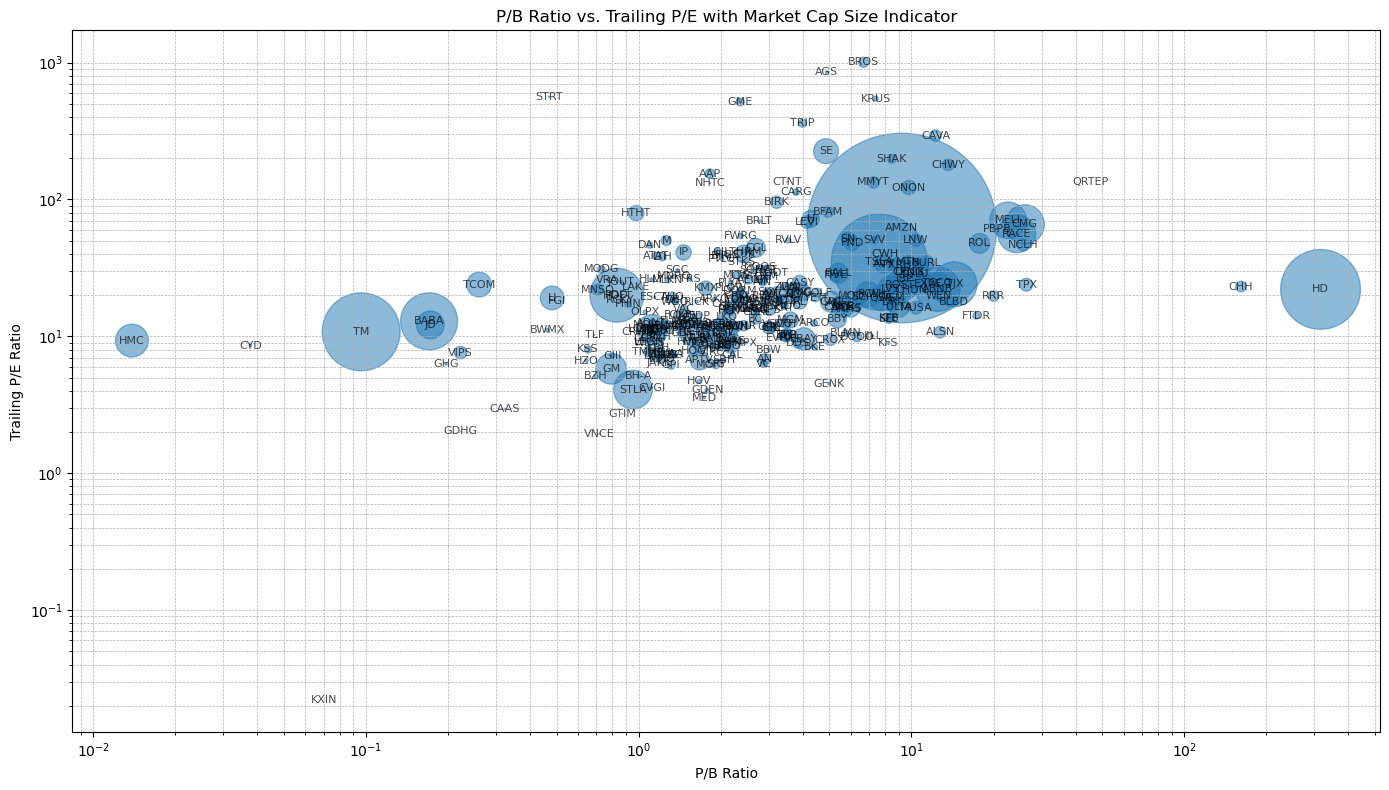

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


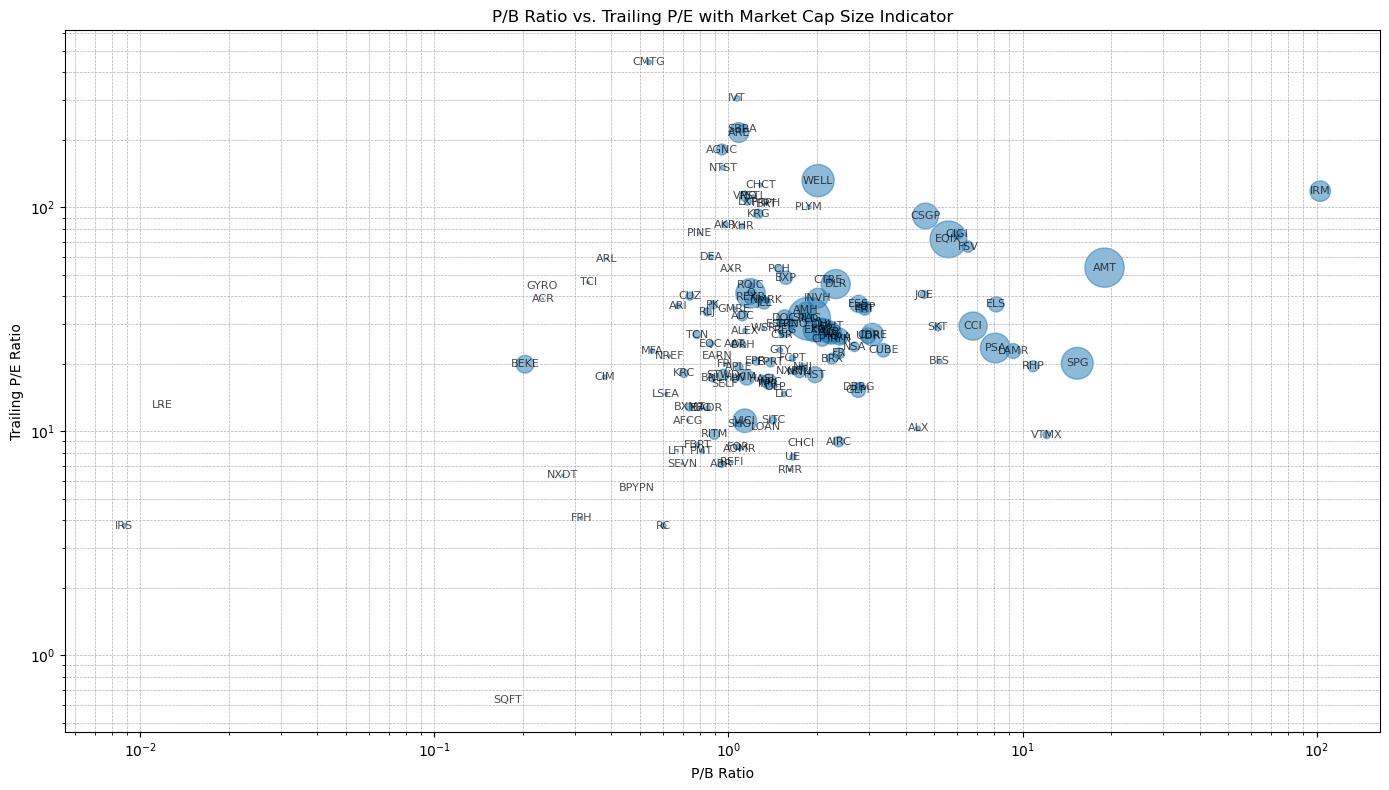

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


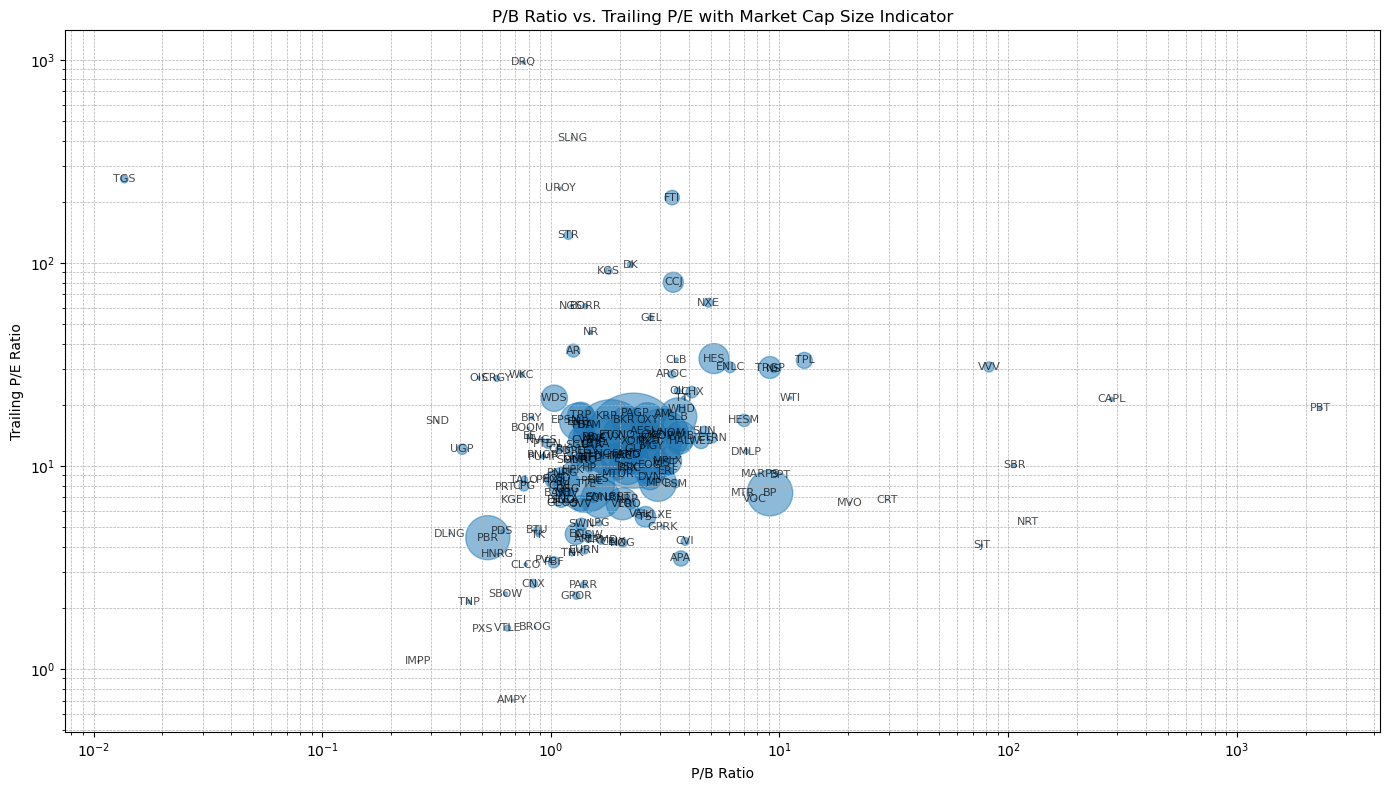

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


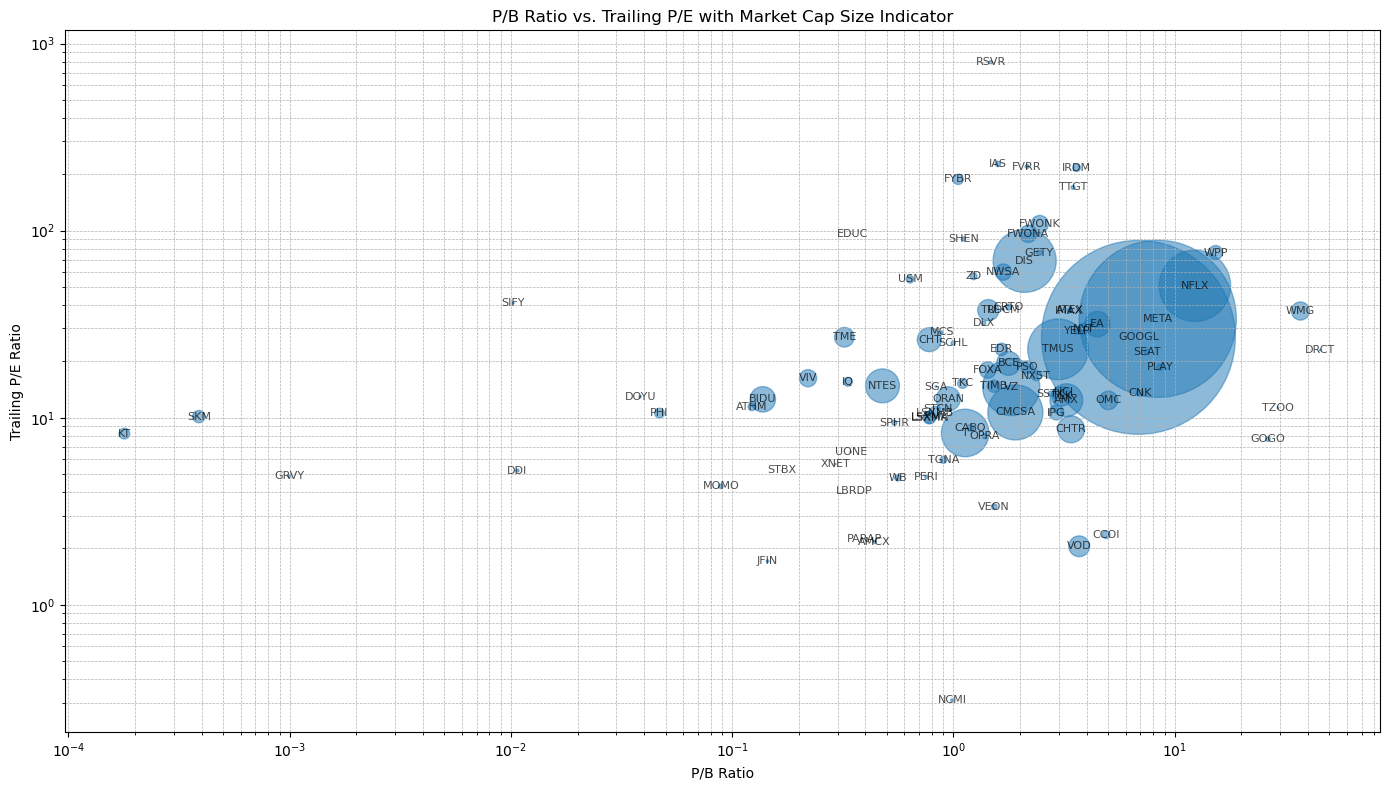

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_50026/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


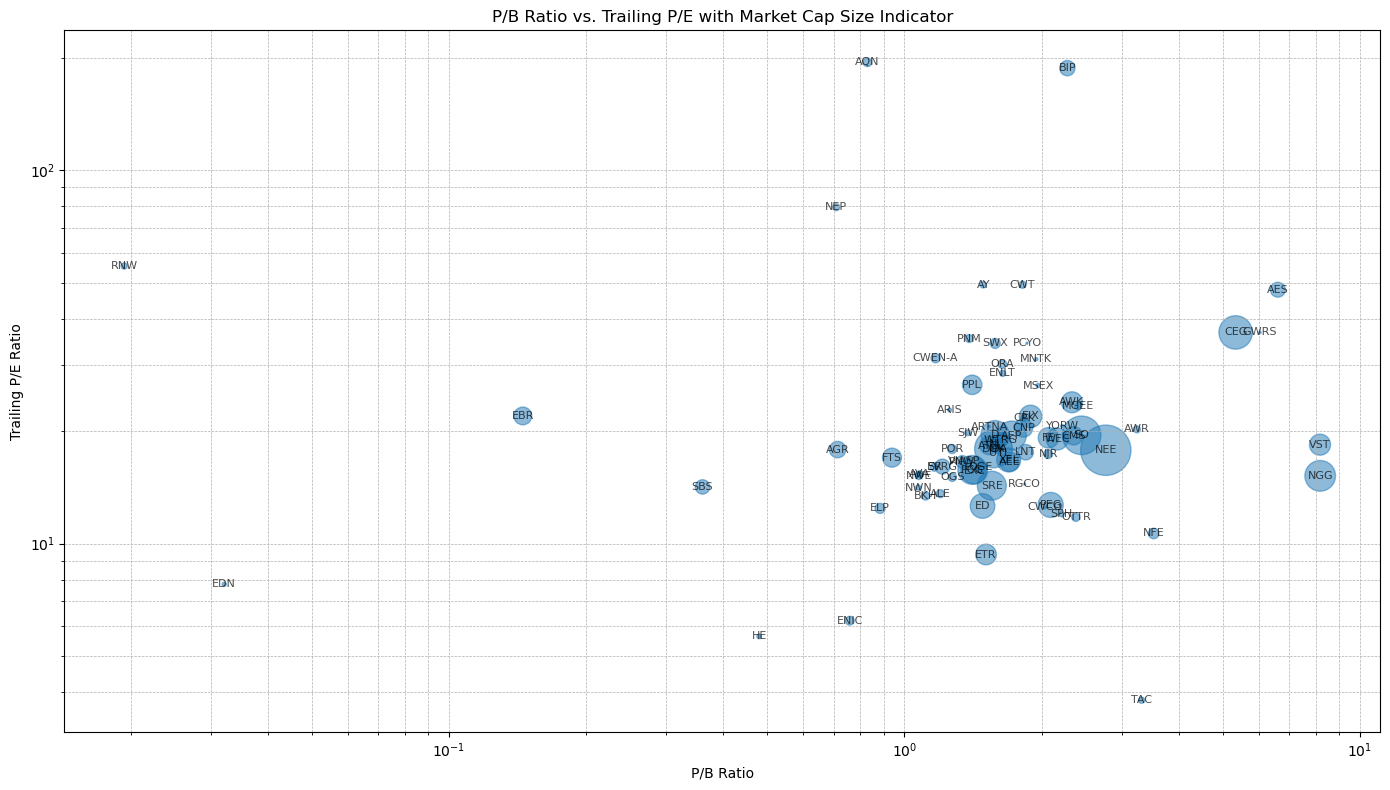

In [20]:
for sector in unique_sectors:
    plot_pe_pb_with_marketcap(sector_results[sector])